In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
import imageio as io
import glob 
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from scipy import stats 

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('paper.mplstyle')

# read data

In [2]:
# make a frame with station names as column and time as row
# first, make an empty frame with desired time as column

date_start = datetime.datetime(2022, 1, 15, 0, 0, 0)
date_end = datetime.datetime(2022, 1, 20, 0, 0, 0)
days = pd.date_range(date_start, date_end, freq='1min') # MUST have same granularity as txt data!

df_empty = pd.DataFrame({'time': days})

df_empty.head()

# second, insert pressure data into frame!

all_files = glob.glob('data/raw_data/*.txt')
all_files.sort()

for i in range(len(all_files)):
    df_tmp = pd.read_csv(all_files[i], header=0, skiprows=0, usecols=(0,5)) # station, pressure
    df_tmp.columns = ['station', 'pressure']
    if df_tmp.shape[0] > 0: # non empty data
        pressure_tmp = df_tmp['pressure']
        station_tmp = df_tmp['station'][0]
        df_empty[station_tmp] = pressure_tmp

stations_non_empty = df_empty.columns[1:].tolist()
print(f'# of non-empty stations: {len(stations_non_empty)}')

# of non-empty stations: 880


In [3]:
# get location of all stations and transform to geopandas frame
df_stations = pd.read_csv('data/stations_US.csv', index_col=0)

df_stations = gpd.GeoDataFrame(
    df_stations, geometry=gpd.points_from_xy(df_stations['lon'], df_stations['lat']))
print('total number of stations: ' + str(len(df_stations)))

all_stations = list(df_stations['station'])
df_stations.head()

total number of stations: 2785


,station,lon,lat,geometry
0,PADK,-176.6460,51.8780,POINT (-176.64600 51.87800)
1,PAKH,-154.1800,56.9400,POINT (-154.18000 56.94000)
2,PAUT,-165.6041,54.1446,POINT (-165.60410 54.14460)
3,PALP,-150.9447,70.3443,POINT (-150.94470 70.34430)
4,PAFM,-157.8575,67.1063,POINT (-157.85750 67.10630)


In [5]:
# get world map
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


# data cleaning

In [6]:
# clean nulls
df_series = df_empty.copy()
df_series = df_series[df_series.columns[df_series.isnull().mean() < 0.9]]
df_series.head()

stations = df_series.columns[1:]

# delete stations with no data
for s in df_stations['station']:
    if s not in stations:
        df_stations.drop(df_stations[df_stations['station']==s].index, inplace=True)
    
print(df_series.shape)
print(df_stations.shape)

(7201, 879)
(878, 4)


In [9]:
# visualize pressure gradients for a station
def show_gradient(s):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df_series['time'], -1 + df_series[s]/df_series[s][0], label='shifted relative pressure', color='dodgerblue')
    ax.plot(df_series['time'], df_series[s].pct_change(periods=5), '--', label='percentage change', color='darkorange')

    # ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=6))
    ax.set_xlabel('time')
    ax.set_ylabel('relative pressure')
    plt.gcf().autofmt_xdate() # Rotation
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title('Jan.15, 2022, ' + s)
    plt.show()

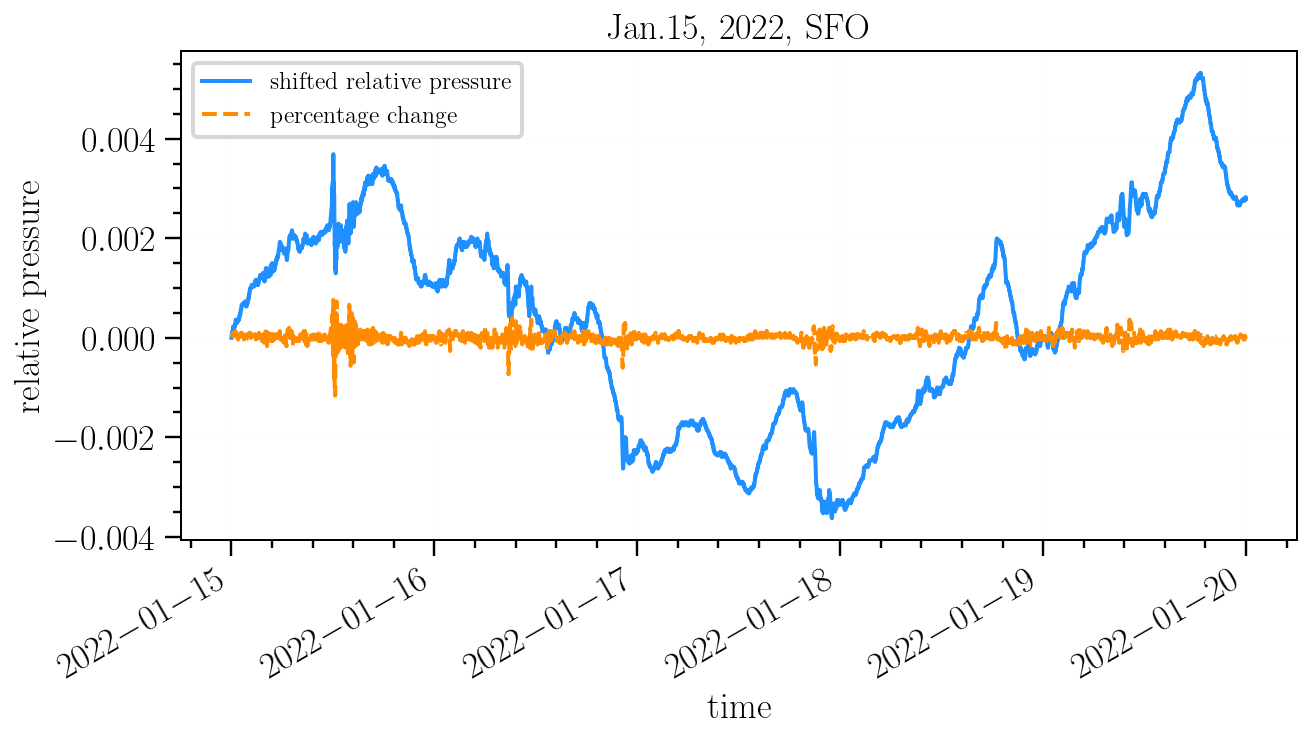

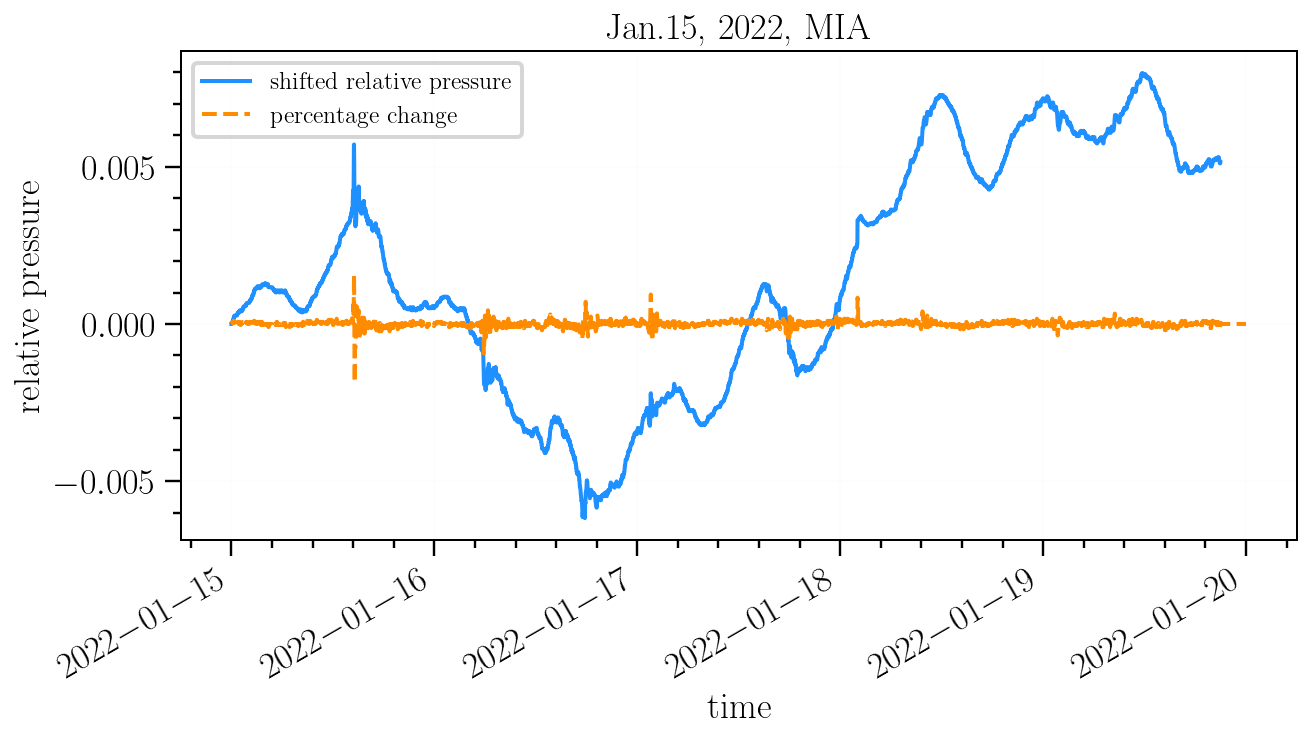

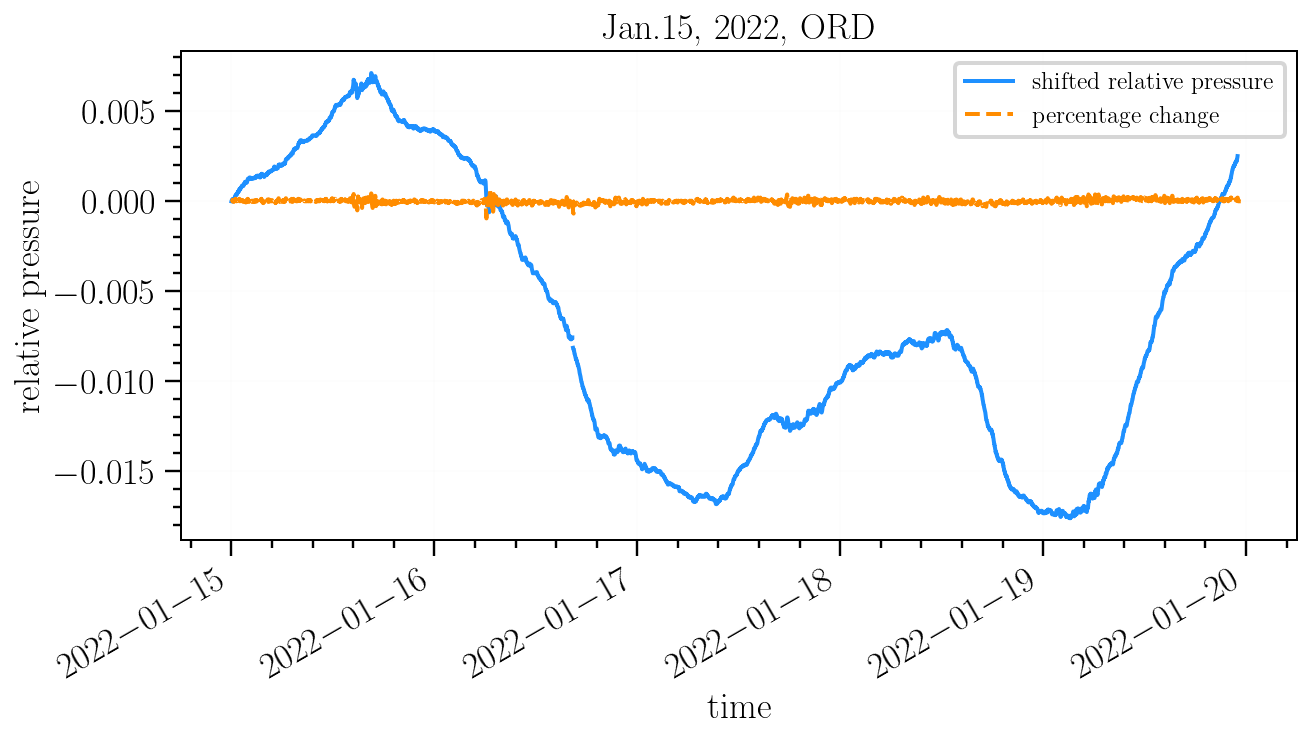

In [10]:
show_gradient('SFO')
show_gradient('MIA')
show_gradient('ORD')

In [11]:
# calculate percent change and find time of shock wave arriving
curr_period = 5

t_shock = []
dt_shock = []
amplitude = []
for s in df_stations['station']:
    changes = df_series[s].pct_change(periods=curr_period) # find percentage change
    t_min = df_series['time'].loc[changes == np.min(changes)] # TimeStamp corresponding to most negative change

    # plt.figure()
    # plt.plot(df_series['time'], changes)
    # plt.plot(t_min, np.min(changes), 'ro')
    # # break
    amplitude.append(np.abs(np.min(changes)))
    t_shock.append(pd.Timestamp(t_min.values[0]))
    dt_shock.append((pd.Timestamp(t_min.values[0]) - datetime.datetime(2022, 1, 15, 0, 0, 0)).total_seconds())

# create shock wave time columns
df_stations['t_shock'] = t_shock
df_stations['dt_shock'] = dt_shock
df_stations['shock_amplitude'] = amplitude
# df_stations = df_stations[df_stations['t_shock']>0]
df_stations.head()

,station,lon,lat,geometry,t_shock,dt_shock,shock_amplitude
6,PANC,-150.0261,61.1697,POINT (-150.02610 61.16970),2022-01-15 12:56:00,46560.0,0.001766
14,PABR,-156.7922,71.2826,POINT (-156.79220 71.28260),2022-01-17 08:06:00,201960.0,0.000961
16,PABE,-161.8264,60.7858,POINT (-161.82640 60.78580),2022-01-15 12:44:00,45840.0,0.000779
17,PABT,-151.5189,66.9165,POINT (-151.51890 66.91650),2022-01-15 13:27:00,48420.0,0.001131
34,PACV,-145.4511,60.4889,POINT (-145.45110 60.48890),2022-01-15 13:01:00,46860.0,0.001519


(878, 7)
(7201, 879)


Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1319 ticks ([19006.756944444445, ..., 19012.24861111111]), which e

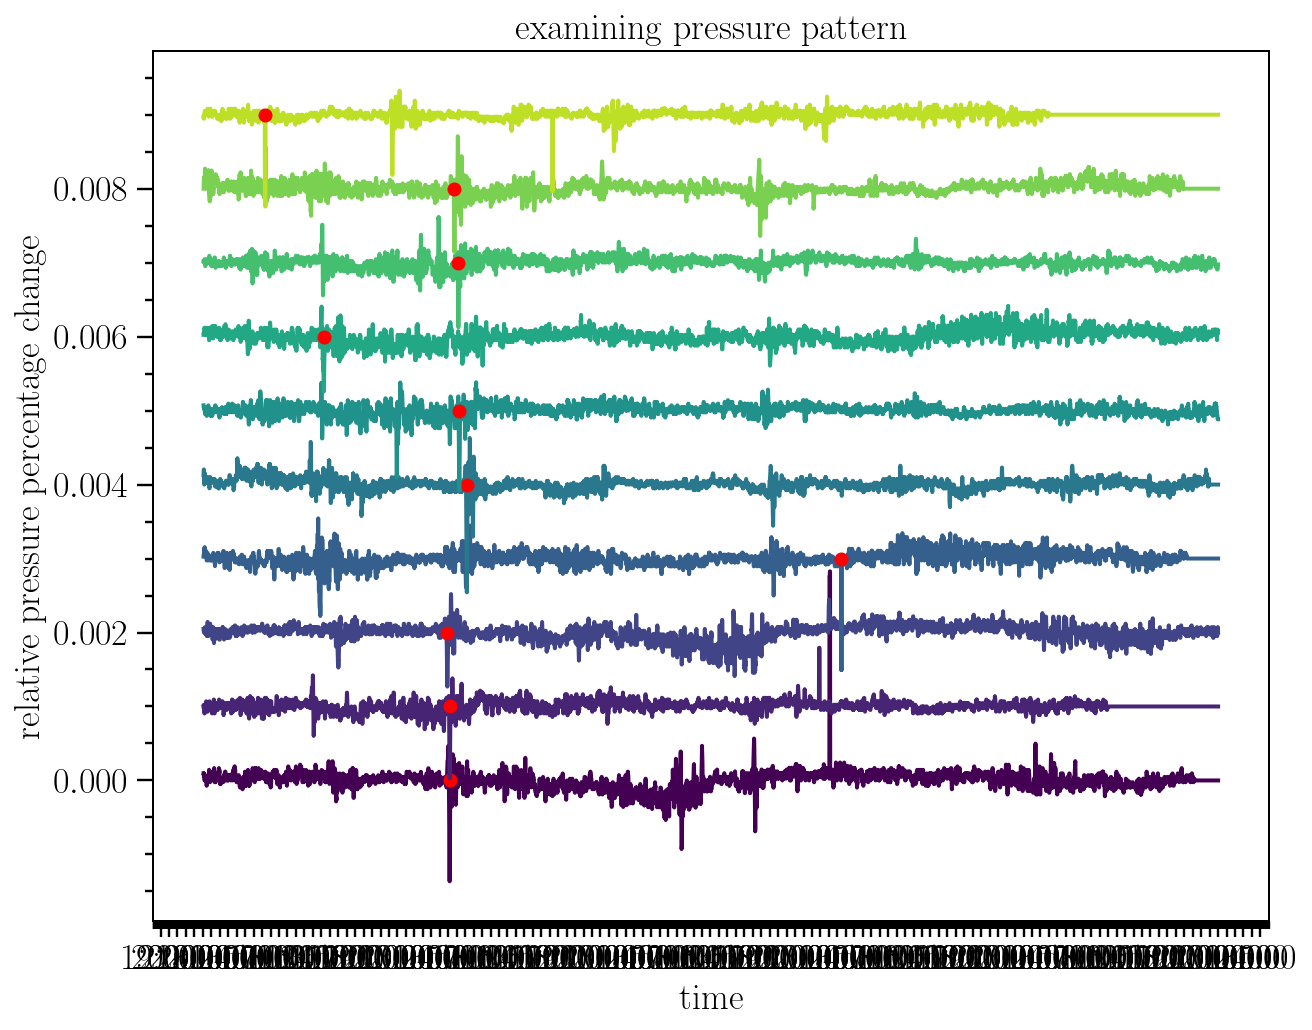

In [12]:
# visualize pressure gradients for all stations
print(df_stations.shape)
print(df_series.shape)

fig, ax = plt.subplots(figsize=(10,8))
cm = matplotlib.cm.get_cmap()

n_toshow = 10
for i in range(n_toshow):
    s = stations[i]
    ax.plot(df_series['time'], i/1000 + 0.7 * df_series[s].pct_change(periods=curr_period), color=cm(i/n_toshow))
    ax.plot(df_stations[df_stations['station']==s]['t_shock'], i/1000, 'o', color='red')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=6))
ax.set_xlabel('time')
ax.set_ylabel('relative pressure percentage change')
plt.title('examining pressure pattern')
# plt.xlim(datetime.datetime(2022, 1, 15, 10, 0), datetime.datetime(2022, 1, 15, 15, 0))
plt.show()

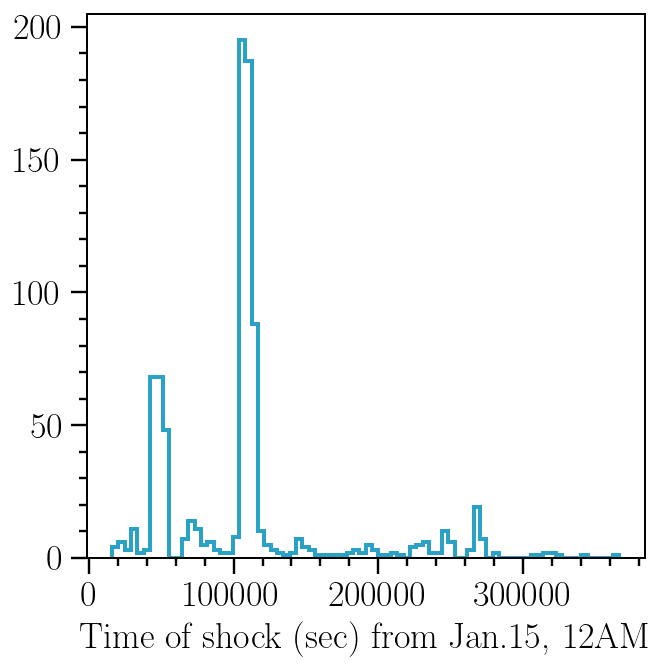

In [13]:
# distribution of shock wave time?

plt.hist(df_stations['dt_shock'],bins=80, histtype='step')
plt.xlabel('Time of shock (sec) from Jan.15, 12AM')
plt.show()

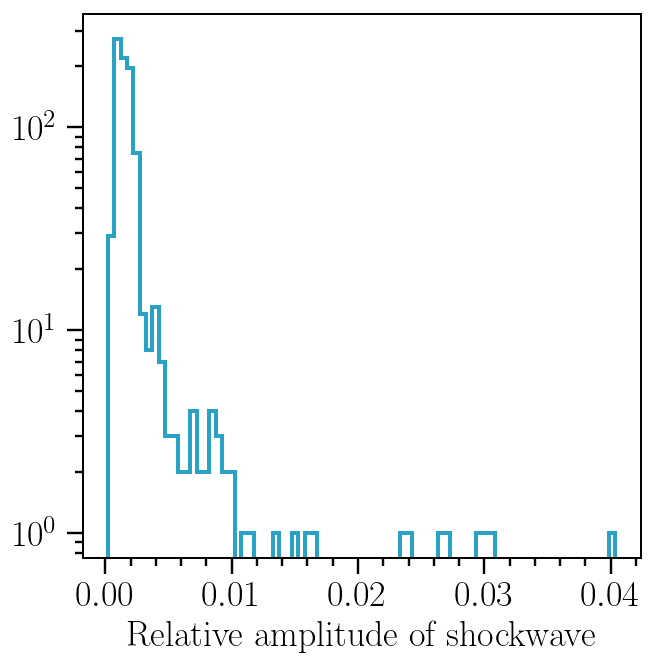

In [14]:
plt.hist(df_stations['shock_amplitude'],bins=80, histtype='step', log=True)
plt.xlabel('Relative amplitude of shockwave')
plt.show()

Text(0, 0.5, 'Relative amplitude of shockwave')

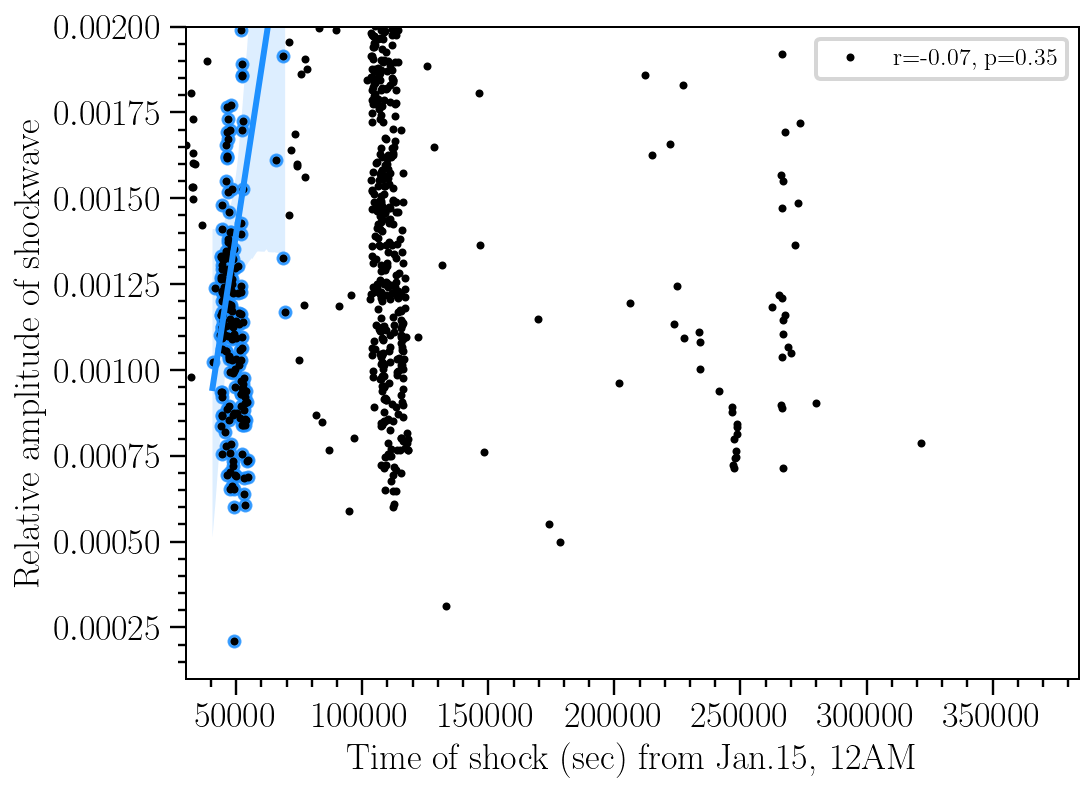

In [15]:
plt.figure(figsize=(8,6))

df_visualize = df_stations[(df_stations['dt_shock'] > 40000) & (df_stations['dt_shock'] < 70000)]
r,p= stats.spearmanr(df_visualize['dt_shock'], df_visualize['shock_amplitude'])

plt.plot(df_stations['dt_shock'], df_stations['shock_amplitude'], '.',color='black',label=f'r={np.round(r,2)}, p={np.round(p,2)}')
sns.regplot(x="dt_shock", y="shock_amplitude", data=df_visualize, color='dodgerblue')

plt.xlim(30000,)
plt.ylim(1e-4,0.2*1e-2)
plt.legend()

plt.xlabel('Time of shock (sec) from Jan.15, 12AM')
plt.ylabel('Relative amplitude of shockwave')

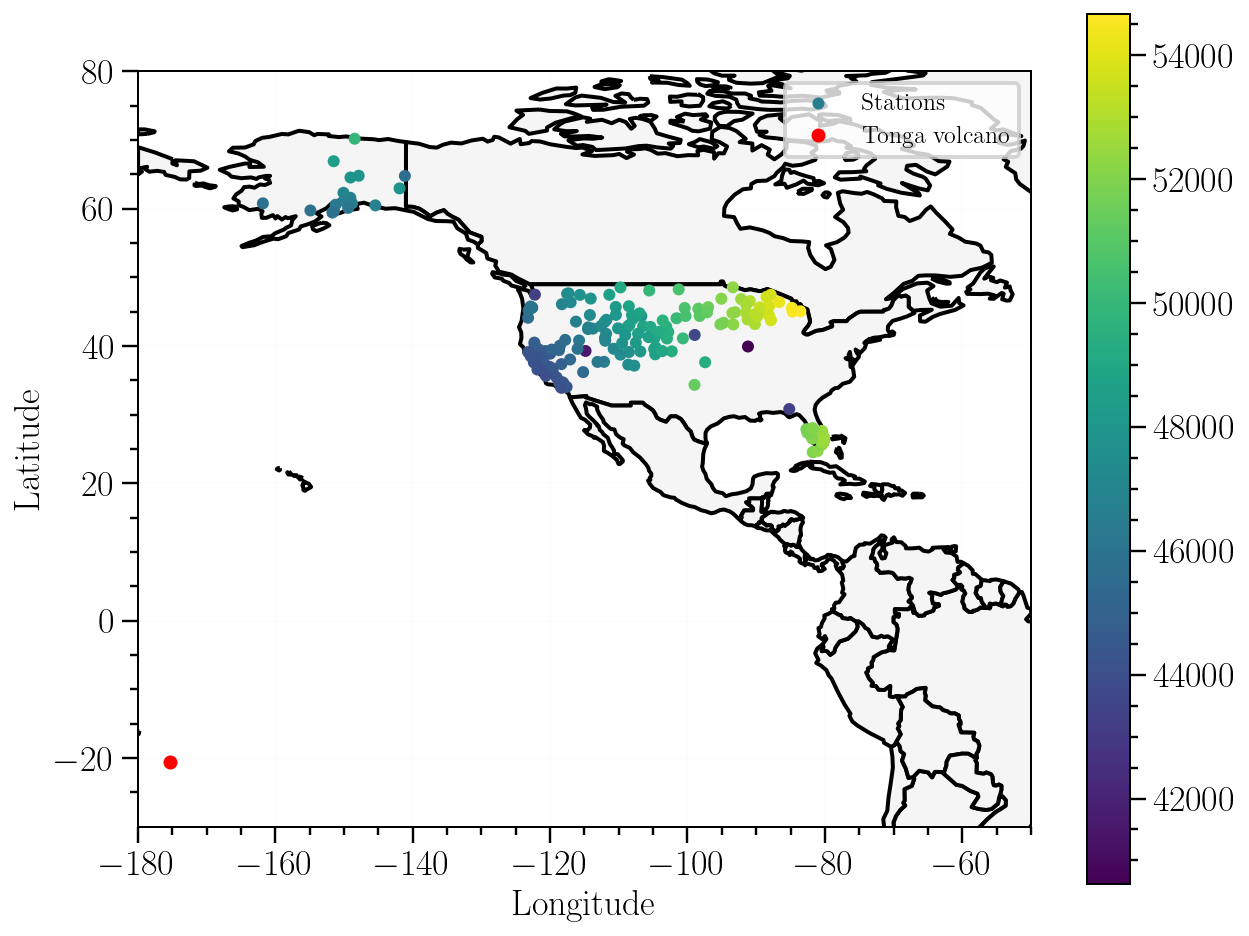

In [16]:
# visualize shock wave!

cut = (df_stations['dt_shock'] > 40000) & (df_stations['dt_shock'] < 55000)
fig, ax = plt.subplots(figsize=(10,8))
df_world.plot(ax=ax, color='whitesmoke', edgecolor='black')
im = df_stations[cut].plot(ax=ax, column=df_stations['dt_shock'][cut],
                           label='Stations', cmap='viridis', legend=True, markersize=16)
ax.plot(-175.385,-20.55, 'o', color='red', label='Tonga volcano')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(-180, -50)
plt.ylim(-30,80)
plt.show()

In [85]:
# save shock wave as png frames!

for t in np.arange(40000, 56000, 200):
    fig, ax = plt.subplots(figsize=(8,6))
    cm = matplotlib.cm.get_cmap('coolwarm')
    df_world.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5)
    for s in range(len(df_stations)):
        station = df_stations.iloc[s]
        if 40000 < station['t_shock'] < 55000:
            cval = 1 - np.abs(station['t_shock'] - t)/12000
            color = cm(cval)
            ax.plot(station['lon'],station['lat'],'o',color=color, markersize=5*cval**2)
        
    ax.plot(-175.385,-20.55, '*', color='m', markersize=10, label='Tonga volcano')
    ax.plot()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, -50)
    ax.set_ylim(-30,80)
    ax.set_title(str(datetime.datetime(2022, 1, 15, 15, 0) + datetime.timedelta(seconds=int(t))) + ' (UTC)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.legend(prop={'size':15})
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    
    plt.savefig('data_animation/frame_' +str(t).zfill(2) + '.png', dpi=150)
    plt.close()

In [86]:
# save png as movie

images = []
fs = glob.glob('data_animation/*.png')
fs.sort()
for f in fs:
    images.append(io.imread(f))

In [87]:
# export to gif

io.mimsave('final_cut.gif', images, fps=40)

<img src="final_cut.gif">